### Outlier Detection using autoencoders-First version
### Using  the whole data
#### Edgar Acuna
#### Abril 2020

In [19]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
url= "https://academic.uprm.edu/eacuna/diabetes.dat"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_table(url, names=names)
yd=data['class']
Xd=data.iloc[:,0:8]

In [21]:
from sklearn.preprocessing import  StandardScaler
cols_to_norm = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']
scaler = MinMaxScaler()
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])
data.shape

(768, 9)

In [22]:
train_x = data.drop(['class'], axis=1) #drop the class column
train_x.info()
train_x = train_x.values #transform to ndarray
#train_x.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
preg    768 non-null float64
plas    768 non-null float64
pres    768 non-null float64
skin    768 non-null float64
test    768 non-null float64
mass    768 non-null float64
pedi    768 non-null float64
age     768 non-null float64
dtypes: float64(8)
memory usage: 48.1 KB


In [23]:
# No of Neurons in each Layer 
nb_epoch = 20
batch_size = 50
input_dim = train_x.shape[1] #num of columns, 8
encoding_dim = 4
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 24        
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________


In [24]:
import datetime
autoencoder.compile(optimizer='adam', loss='mse' )

t_ini = datetime.datetime.now()
history = autoencoder.fit(train_x, train_x,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.1,
                        verbose=0
                        )

t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - 
t_ini).total_seconds()))



df_history = pd.DataFrame(history.history) 

Time to run the model: 2.277135 Sec.


In [25]:
predictions = autoencoder.predict(train_x)
print(predictions)
train_x.shape

[[0.28479186 0.6974724  0.6402944  ... 0.5399302  0.17889307 0.2767555 ]
 [0.15078995 0.47442877 0.46398443 ... 0.37341928 0.11160305 0.12865937]
 [0.32405236 0.73809767 0.6347775  ... 0.5620985  0.22996637 0.28215235]
 ...
 [0.2577511  0.6526467  0.60513955 ... 0.50652647 0.16508214 0.247152  ]
 [0.20551175 0.565774   0.5365889  ... 0.4416986  0.1387499  0.18953916]
 [0.15500638 0.48147848 0.4696051  ... 0.37869263 0.11368032 0.1333678 ]]


(768, 8)

In [26]:
mse = np.mean(np.power(train_x- predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse, 'Label': yd}, index=yd.index)
df_error.describe()

,reconstruction_error,Label
count,768.000000,768.000000
mean,0.025236,1.348958
std,0.018928,0.476951
min,0.001621,1.000000
25%,0.012180,1.000000
50%,0.020970,1.000000
75%,0.033355,2.000000
max,0.184195,2.000000


In [27]:
dfOutliers = df_error.index[df_error.reconstruction_error > .15].tolist()
len(dfOutliers)

2

In [28]:
print(dfOutliers)

[445, 579]


In [29]:
y=df_error['reconstruction_error'].tolist()
x = df_error.index.tolist()

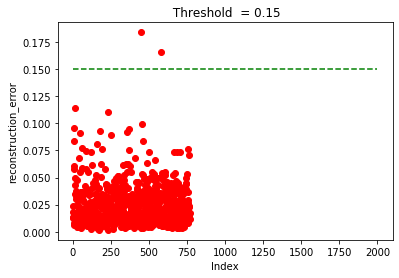

In [30]:
thresh=0.15
plt.plot(x, y, 'ro')
plt.ylabel('reconstruction_error')
plt.xlabel('Index')
plt.title(' Threshold  = ' +str(thresh))
plt.plot([0,2000],[thresh,thresh],"g--")

In [31]:
#cleaning the data from outliers
data3=data.drop(dfOutliers,axis=0)

### Outlier effect on the LDA Classifier

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
ldadis = LinearDiscriminantAnalysis().fit(Xd,yd)
scores = cross_val_score(ldadis, Xd, yd, cv=10)
print("Accuracy using LDA: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy using LDA: 0.77 (+/- 0.07)


In [33]:
y=data3['class']
X=data3.iloc[:,0:8]
#Haciendo el analisis discriminante y calculando el porcentaje de precision
ldadis = LinearDiscriminantAnalysis().fit(X,y)
scores = cross_val_score(ldadis, X, y, cv=10)
scores
print("Accuracy using LDA after outlier removal: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy using LDA after outlier removal: 0.77 (+/- 0.07)


#### Outlier effect on the KNN classifier

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
neigh = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(neigh, Xd, yd, cv=10)
scores
print("Accuracy using k=5 neighbors: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy using k=5 neighbors: 0.72 (+/- 0.09)


In [35]:
y=data3['class']
X=data3.iloc[:,0:8]
y1=y.as_matrix()
X1=X.as_matrix()
neigh = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(neigh, X1, y1, cv=10)
scores
print("Accuracy using k=5 neighbors after outlier removal: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy using k=5 neighbors after outlier removal: 0.75 (+/- 0.10)
